In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

In [2]:
identifier_name = 'flight_id'

features_names = [
 'month_day',
 'month',
 'day',
 'actual_offblock_time_hour_minute',
 'actual_offblock_time_hour',
 'actual_offblock_time_minute',
 'adep',
 'country_code_adep',
 'arrival_time_hour_minute',
 'arrival_time_hour',
 'arrival_time_minute',
 'ades',
 'country_code_ades',
 'aircraft_type',
 'wtc',
 'airline',
 'flight_duration',
 'taxiout_time',
 'flown_distance',
 'latitude_count',
 'latitude_mean',
 'latitude_std',
 'latitude_min',
 'latitude_25percentile',
 'latitude_median',
 'latitude_75percentile',
 'latitude_max',
 'longitude_count',
 'longitude_mean',
 'longitude_std',
 'longitude_min',
 'longitude_25percentile',
 'longitude_median',
 'longitude_75percentile',
 'longitude_max',
 'altitude_count',
 'altitude_mean',
 'altitude_std',
 'altitude_min',
 'altitude_25percentile',
 'altitude_median',
 'altitude_75percentile',
 'altitude_max',
 'groundspeed_count',
 'groundspeed_mean',
 'groundspeed_std',
 'groundspeed_min',
 'groundspeed_25percentile',
 'groundspeed_median',
 'groundspeed_75percentile',
 'groundspeed_max',
 'track_count',
 'track_mean',
 'track_std',
 'track_min',
 'track_25percentile',
 'track_median',
 'track_75percentile',
 'track_max',
 'vertical_rate_count',
 'vertical_rate_mean',
 'vertical_rate_std',
 'vertical_rate_min',
 'vertical_rate_25percentile',
 'vertical_rate_median',
 'vertical_rate_75percentile',
 'vertical_rate_max',
 'track_unwrapped_count',
 'track_unwrapped_mean',
 'track_unwrapped_std',
 'track_unwrapped_min',
 'track_unwrapped_25percentile',
 'track_unwrapped_median',
 'track_unwrapped_75percentile',
 'track_unwrapped_max',
 'u_component_of_wind_count',
 'u_component_of_wind_mean',
 'u_component_of_wind_std',
 'u_component_of_wind_min',
 'u_component_of_wind_25percentile',
 'u_component_of_wind_median',
 'u_component_of_wind_75percentile',
 'u_component_of_wind_max',
 'v_component_of_wind_count',
 'v_component_of_wind_mean',
 'v_component_of_wind_std',
 'v_component_of_wind_min',
 'v_component_of_wind_25percentile',
 'v_component_of_wind_median',
 'v_component_of_wind_75percentile',
 'v_component_of_wind_max',
 'temperature_count',
 'temperature_mean',
 'temperature_std',
 'temperature_min',
 'temperature_25percentile',
 'temperature_median',
 'temperature_75percentile',
 'temperature_max',
 'specific_humidity_count',
 'specific_humidity_mean',
 'specific_humidity_std',
 'specific_humidity_min',
 'specific_humidity_25percentile',
 'specific_humidity_median',
 'specific_humidity_75percentile',
 'specific_humidity_max'
]

target_name = 'tow'

global_random_state = 123

In [3]:
encoded_challenge_set = pd.read_csv('data/encoded_challenge_set.csv')
encoded_challenge_set = encoded_challenge_set.fillna(0)
features = encoded_challenge_set[features_names]
target = encoded_challenge_set[target_name]

In [4]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=global_random_state)

In [5]:
param_grid = {
    'n_estimators': list(range(1,102,15)),
    'max_depth': list(range(1, 11, 3)),
    'learning_rate': [x / 10 for x in list(range(1, 10, 3))],
    'subsample': [x / 10 for x in list(range(1, 11, 3))],
    'colsample_bytree': [x / 10 for x in list(range(1, 11, 3))]
}

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use RMSE (negative because scikit-learn maximizes scores)
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(features, target)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best RMSE:", -grid_search.best_score_) # Negate the score to get RMSE

Fitting 3 folds for each of 1344 candidates, totalling 4032 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 91, 'subsample': 1.0}
Best RMSE: 3180.0138387283455


<Figure size 1000x800 with 0 Axes>

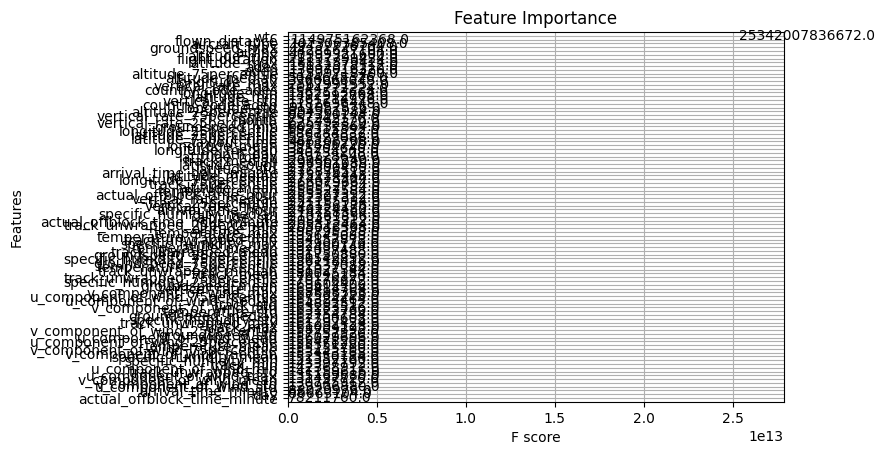

In [6]:
best_model = grid_search.best_estimator_

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [7]:
booster = best_model.get_booster()

# Create a DataFrame with all feature names
all_features = pd.DataFrame(features.columns, columns=['Feature'])

# Get the importance of the features
importance_dict = booster.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])

# Merge with all features to include those with zero importance
importance_full_df = all_features.merge(importance_df, on='Feature', how='left').fillna(0)

# Sort the DataFrame in ascending order
importance_full_df_sorted = importance_full_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_full_df_sorted

,Feature,Importance
0,month_day,4971.0
1,aircraft_type,3157.0
2,vertical_rate_std,1963.0
3,vertical_rate_max,1869.0
4,actual_offblock_time_hour_minute,1850.0
...,...,...
102,track_unwrapped_count,0.0
103,track_count,0.0
104,groundspeed_count,0.0
105,temperature_count,0.0


In [8]:
print(list(importance_full_df_sorted["Importance"].values))

[4971.0, 3157.0, 1963.0, 1869.0, 1850.0, 1694.0, 1375.0, 1345.0, 1309.0, 1227.0, 1219.0, 1138.0, 1080.0, 1073.0, 1040.0, 1039.0, 972.0, 937.0, 917.0, 907.0, 907.0, 834.0, 824.0, 812.0, 808.0, 767.0, 744.0, 732.0, 730.0, 727.0, 717.0, 697.0, 648.0, 622.0, 621.0, 583.0, 573.0, 563.0, 560.0, 558.0, 557.0, 553.0, 552.0, 551.0, 535.0, 532.0, 530.0, 513.0, 513.0, 509.0, 501.0, 496.0, 488.0, 479.0, 478.0, 463.0, 463.0, 462.0, 454.0, 454.0, 453.0, 449.0, 445.0, 442.0, 437.0, 435.0, 433.0, 432.0, 431.0, 428.0, 427.0, 414.0, 414.0, 409.0, 404.0, 401.0, 397.0, 394.0, 391.0, 383.0, 364.0, 363.0, 347.0, 340.0, 335.0, 333.0, 332.0, 328.0, 314.0, 294.0, 282.0, 271.0, 239.0, 186.0, 55.0, 40.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [9]:
print(list(importance_full_df_sorted["Feature"].values))

['month_day', 'aircraft_type', 'vertical_rate_std', 'vertical_rate_max', 'actual_offblock_time_hour_minute', 'flown_distance', 'day', 'adep', 'flight_duration', 'altitude_75percentile', 'airline', 'groundspeed_min', 'ades', 'arrival_time_hour_minute', 'altitude_max', 'vertical_rate_75percentile', 'actual_offblock_time_minute', 'altitude_median', 'longitude_max', 'latitude_std', 'latitude_min', 'vertical_rate_mean', 'latitude_count', 'longitude_min', 'latitude_max', 'longitude_std', 'temperature_max', 'taxiout_time', 'arrival_time_minute', 'altitude_25percentile', 'altitude_std', 'altitude_min', 'groundspeed_std', 'latitude_mean', 'vertical_rate_min', 'altitude_mean', 'groundspeed_max', 'longitude_mean', 'latitude_25percentile', 'temperature_min', 'groundspeed_25percentile', 'u_component_of_wind_min', 'u_component_of_wind_std', 'country_code_adep', 'latitude_75percentile', 'country_code_ades', 'track_std', 'track_mean', 'v_component_of_wind_max', 'v_component_of_wind_std', 'specific_hum